# Tutorial 2: Finite Data & The Generalization Gap

**Goal:** Move from the theoretical "Infinite Data" limit to the real-world regime of **Finite Data**, handle overfitting, and learn the **"Max-Test" Heuristic** for robust estimation.

In Tutorial 1, we generated fresh data at every step (Infinite Data), effectively optimizing the population Mutual Information directly. In the real world, we have fixed datasets. This introduces a dangerous trap: **Overfitting**.

In this tutorial, we will:
1.  **The Trap (Naive Estimation):** We will train on a fixed dataset of 3,000 samples and use a naive estimator (average of the last few epochs). We will see that this fails catastrophically, estimating wrong information due to overfitting.

2.  **The Investigation (Train vs Test):** We will look under the hood at the training dynamics. By plotting Train and Test MI curves, we will visualize the "Generalization Gap" and see exactly when the model starts memorizing the data.

3.  **The Solution (Max-Test Heuristic):** We will implement a robust selection strategy: using the *Training* value at the point where the *Test* value is maximized. We will show that this correctly recovers the Intrinsic Dimensionality (ID) even when the network is vastly over-parameterized.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter1d, median_filter
from typing import List, Tuple

# Library Imports
from dim_est.run.run_dsib_single_experiment import run_dsib_finite

# Plotting Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams.update({
    "font.family": "serif", "font.serif": "Times New Roman", "mathtext.fontset": "cm",
    'figure.dpi': 100, 'font.size': 16, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.fontsize': 14
})

# Global Constants
BATCH_SIZE = 128   # Standard batch size
N_SAMPLES = 3000   # A realistically small dataset size
N_EPOCHS = 200     # Long enough to overfit
SMOOTH_WIN = 5    # Smoothing window
SMOOTH_SIGMA = 1  # Smoothing sigma

## Part 0: Helper Functions

We need a wrapper to run the **Finite Data** experiment loop. Unlike Tutorial 1, `run_dsib_finite` returns two traces: `mi_train` and `mi_test`.

We also define our **Naive** and **Robust** metric extractors here.

In [2]:
def run_finite_sweep(kz_list, dataset_cfg, dataset_type="joint_gaussian"):
    """Runs the finite estimator for a list of kz values."""
    results = []
    print(f"--- Running Finite Data Sweep (N={N_SAMPLES}) ---")
    
    for kz in tqdm(kz_list, leave=False):
        traces, _ = run_dsib_finite(
            dataset_type=dataset_type,
            setup="finite_data_epoch",
            outfile="temp_finite.h5", 
            dataset_overrides=dataset_cfg, 
            critic_type="hybrid", 
            critic_overrides={"embed_dim": kz},
            training_overrides={
                "n_epoch": N_EPOCHS, 
                "batch_size": BATCH_SIZE, 
                "n_samples": N_SAMPLES, 
                "show_progress": False,
                "lr": 5e-4,
                "patience": N_EPOCHS  # Disable early stopping for full trace
            }
        )
        
        mi_train, mi_test = traces
        results.append({
            "kz": kz,
            "Trace Train": mi_train,
            "Trace Test": mi_test
        })
    return results

def get_naive_estimate(trace):
    """
    Naive Heuristic: Just take the final value at the end of training.
    In an overfitted regime, this will likely be the highest value (memorization).
    """
    return trace[-1]

def smooth(arr, sigma=1, med_win=5):
    hist = np.array(arr)
    if len(hist) < 2: return hist
    nan_mask = np.isnan(hist)
    valid_hist = hist[~nan_mask]
    if len(valid_hist) == 0: return hist
    hist[nan_mask] = valid_hist[-1]
    if med_win > 1 and len(hist) >= med_win:
        hist = median_filter(hist, size=med_win, mode='reflect')
    if sigma > 0: hist = gaussian_filter1d(hist, sigma=sigma, mode='reflect')
    hist[nan_mask] = np.nan
    return hist

def get_robust_estimate(train_trace, test_trace, smooth_win=5):
    """
    Max-Test Heuristic:
    1. Smooth the traces to reduce batch noise.
    2. Find epoch where Test MI is maximized.
    3. Return Train MI at that specific epoch.
    """
    # Simple moving average smoothing
    # s_train = pd.Series(train_trace).rolling(window=smooth_win, min_periods=1).mean().values
    # s_test  = pd.Series(test_trace).rolling(window=smooth_win, min_periods=1).mean().values
    s_train = smooth(train_trace, sigma=SMOOTH_SIGMA, med_win=SMOOTH_WIN)
    s_test  = smooth(test_trace, sigma=SMOOTH_SIGMA, med_win=SMOOTH_WIN)

    # Find peak of test curve
    best_epoch = np.argmax(s_test)
    
    return s_train[best_epoch], best_epoch

## Part 1: The Trap (Naive Sweep)

We construct a **High-Dimensional Teacher Dataset**.
* **Latent ID:** 4 (The truth we want to find).
* **Observation:** 500 Dimensions.
* **Transform:** "Teacher" (Random MLP projection). This creates a complex, non-linear manifold.

We will run a sweep of $k_Z$ (embedding dimension) and calculate MI using the **Naive Method** (just training until the end). 

In [3]:
# --- Configuration: ID=4, Obs=100 ---
cfg_teacher = {
    "latent": {
        "latent_dim": 4,
        "mi_bits": 2.0 
    },
    "transform": {
        "mode": "linear",
        "observe_dim_x": 500,
        "observe_dim_y": 500
    }
}

# Run the sweep
kz_sweep = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
sweep_results = run_finite_sweep(kz_sweep, cfg_teacher, "joint_gaussian")

--- Running Finite Data Sweep (N=3000) ---


  0%|          | 0/10 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5
Run completed; saved to temp_finite.h5


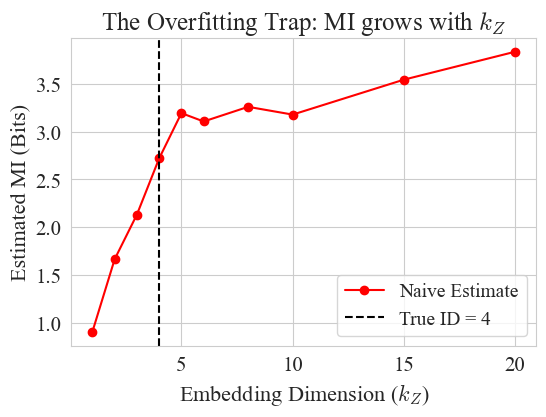

In [4]:
# Apply Naive Heuristic
naive_mi = [get_naive_estimate(r["Trace Train"]) for r in sweep_results]

plt.figure()
plt.plot(kz_sweep, naive_mi, 'o-', color='red', label="Naive Estimate")
plt.axvline(4, color='black', linestyle='--', label="True ID = 4")
plt.xlabel("Embedding Dimension ($k_Z$)")
plt.ylabel("Estimated MI (Bits)")
plt.title("The Overfitting Trap: MI grows with $k_Z$")
plt.legend()
plt.show()

### Observation
Notice the problem? The MI estimate **does not saturate** at 4. Instead, it keeps increasing as we increase $k_Z$. 

**Why?** With finite data, a higher dimensional embedding ($k_Z$) allows the network to memorize individual sample pairs unique to the training set, artificially inflating the MI estimate. We are measuring the dimension of the *noise*, not the data.

## Part 2: The Investigation (Generalization Gap)

To understand what happened, let's pick the correct dimension, **$k_Z = 4$**, and analyze the full training dynamics.

We will overlay the **Training Trace** and the **Test Trace**.

**Note on Data Splitting:**
The library's `run_dsib_finite` automatically handles the data splitting for us.
1. It generates `N_SAMPLES`.
2. It performs a random **90% Train / 10% Test** split.
3. It evaluates the "Test Trace" on the 10% hold-out set at the end of every epoch.
4. This means that what we trained on before is `0.9*N_SAMPLES` and we already have the evaluated tests.

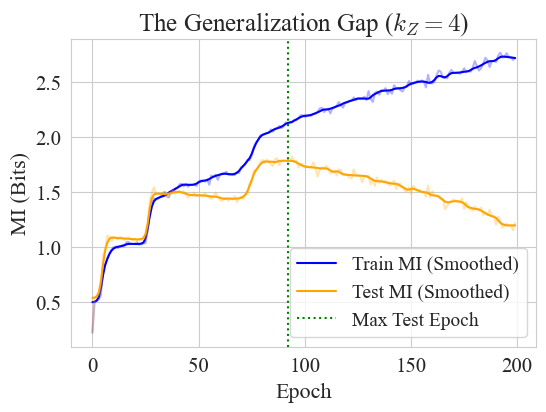

In [6]:
# Extract traces for kz=4 from our previous results
res_kz4 = next(r for r in sweep_results if r['kz'] == 4)
tr_train = res_kz4['Trace Train']
tr_test = res_kz4['Trace Test']

# Calculate smoothing for visualization
smooth_train = smooth(tr_train, sigma=SMOOTH_SIGMA, med_win=SMOOTH_WIN)
smooth_test = smooth(tr_test, sigma=SMOOTH_SIGMA, med_win=SMOOTH_WIN)

plt.figure()
plt.plot(tr_train, alpha=0.3, color='blue')
plt.plot(smooth_train, color='blue', label="Train MI (Smoothed)")

plt.plot(tr_test, alpha=0.3, color='orange')
plt.plot(smooth_test, color='orange', label="Test MI (Smoothed)")

# Mark the peak
peak_epoch = np.argmax(smooth_test)
plt.axvline(peak_epoch, color='green', linestyle=':', label="Max Test Epoch")

plt.xlabel("Epoch")
plt.ylabel("MI (Bits)")
plt.title("The Generalization Gap ($k_Z=4$)")
# plt.xscale('log')
plt.legend()
plt.show()

### The Anatomy of the Curves
1.  **Early Phase:** Both Train and Test MI rise together. The model is learning the true dependency.
2.  **Saturation Phase:** The Test MI peaks and flattens (or even degrades). This is the true information content.
3.  **Overfitting Phase:** The Train MI continues to drift upwards as the model "hacks" the objective using the finite sample size.

**The Lesson:** The true ID is located at the **Training Value** corresponding to the **Peak Test Performance**.

## Part 3: The Solution (Robust Sweep)

Now we re-calculate the sweep results using the **Max-Test Heuristic**.

We don't need to re-run the training; we just re-analyze the traces we collected in Part 1.

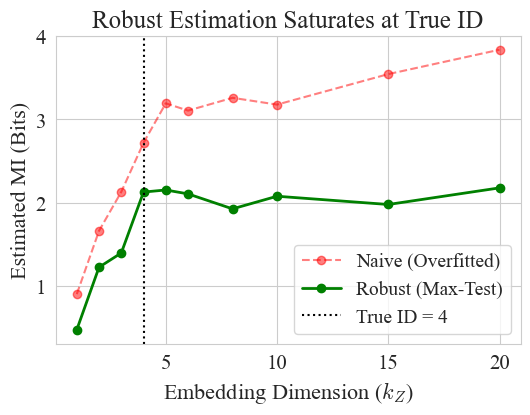

In [7]:
robust_mi = []

for r in sweep_results:
    val, epoch = get_robust_estimate(r["Trace Train"], r["Trace Test"])
    robust_mi.append(val)

# Plot comparison
plt.figure()
plt.plot(kz_sweep, naive_mi, 'o--', color='red', alpha=0.5, label="Naive (Overfitted)")
plt.plot(kz_sweep, robust_mi, 'o-', color='green', linewidth=2, label="Robust (Max-Test)")

plt.axvline(4, color='black', linestyle=':', label="True ID = 4")
# plt.axhline(robust_mi[2], color='green', linestyle=':', alpha=0.3) # Line at saturation level

plt.xlabel("Embedding Dimension ($k_Z$)")
plt.ylabel("Estimated MI (Bits)")
plt.title("Robust Estimation Saturates at True ID")
plt.legend()
plt.show()

### Conclusion

By using the **Max-Test Heuristic**, the estimator becomes robust to architecture size. Even when we set $k_Z=20$ (5x the true dimension), the robust estimator correctly reports an ID of ~4 bits, whereas the naive estimator drifted off to infinity.

**Summary of Best Practices for Finite Data:**
1.  **Always Split Data:** Use a Train/Test split (built-in to `run_dsib_finite`).
2.  **Monitor Test MI:** If Test MI drops while Train MI rises, you are overfitting.
3.  **Use Max-Test:** Report the MI value at the peak of the Test curve, not the end of training.
4.  **Smooth Your Traces:** Batch variance can create false peaks; typically a rolling average of 5-10 epochs is sufficient.